<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/C%2B_Lead_Scoring_Modelv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C+ Lead Scoring Model

In [ ]:
# import base packages into the namespace for this program
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport

from datetime import date 
from datetime import datetime 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import os
import time

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# obtain precision, recall, F1, and support metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# specify the set of classifiers being evaluated
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

## Connect to GBQ

In [ ]:
# Installing Library
!pip install pydata_google_auth

In [ ]:
# Using GBQ shout Out to Hughes
import pandas_gbq
import pydata_google_auth

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=vDRL0jqBC9CdSNVRXqKdWlUL4VF55I&prompt=consent&access_type=offline
Enter the authorization code: 4/tAFRhEdk3B3BmDKYKG_cDn8vZR5jz2uaeHCtwY093ykVw609CQyI7dU


In [ ]:
sql = """
SELECT 
     s.app_name
    ,s.lead_created_date_time
    ,CASE WHEN s.cplus_enrolled_date_time IS NOT NULL THEN 1 ELSE 0 END AS Enrolled
    ,cr.fico9
    ,cr.num_inquiries_last_6m
    ,cr.fdr_specified_creditors_mix
    ,cr.num_Tradelines_open_last_6m
    ,cr.months_since_first_tr_open
    ,CAST(cr.open_creditcard_accounts_creditlimit AS FLOAT64) AS open_creditcard_accounts_creditlimit
    ,cr.num_Tradelines_open_last_3m
    ,cr.credit_report_mnth_delinquent_fdr_eligible_account_types
    ,cr.credit_report_mnth_delinquent_active_tradelines_fdr_eligible_account_types
    ,cr.credit_report_mnth_delinquent_all_tradelines_fdr_eligible_account_types
    ,cr.delinquency_bankruptcy_flag
    ,cr.delinquency_foreclosure_flag
    ,cr.delinquency_chargeoff_flag
    ,cr.delinquency_chargeoff_flag_fdr_eligible_account_types
    ,cr.Amex
    ,cr.at_cu
    ,cr.Discover
    ,cr.Lending_club
    ,cr.synchrony
    ,cr.comenity
    ,cr.citibank
    ,cr.cap_one
    ,cr.barclays
    ,cr.kohls
    ,cr.target
    ,cr.bofa
    ,cr.chase
    ,cr.credit_one_bank, macys
    ,cr.merrick
    ,cr.onemain
    ,cr.us_bank
    ,cr.wells_fargo
    ,cr.open_medical_outstanding_balance
    ,cr.open_auto_outstanding_balance
    ,cr.open_PersonalLoan_outstanding_balance
    ,cr.open_Credit_Card_outstanding_balance
    ,cr.open_StudentLoan_outstanding_balance
    ,cr.open_Mortgage_outstanding_balance
    ,cr.open_Heloc_outstanding_balance
    ,cr.open_Collection_Agency_outstanding_balance
    ,cr.open_Other_outstanding_balance
    ,cr.open_medical_num_tradelines
    ,cr.open_auto_num_tradelines
    ,cr.open_PersonalLoan_num_tradelines
    ,cr.open_Credit_Card_num_tradelines
    ,cr.open_StudentLoan_num_tradelines
    ,cr.open_Mortgage_num_tradelines
    ,cr.open_Heloc_num_tradelines
    ,cr.open_Collection_Agency_num_tradelines
    ,cr.open_Other_num_tradelines
    ,cr.open_medical_monthly_payment_amount
    ,cr.open_auto_monthly_payment_amount
    ,cr.open_PersonalLoan_monthly_payment_amount
    ,cr.open_Credit_Card_monthly_payment_amount
    ,cr.open_StudentLoan_monthly_payment_amount
    ,cr.open_Mortgage_monthly_payment_amount
    ,cr.open_Heloc_monthly_payment_amount
    ,cr.open_Collection_Agency_monthly_payment_amount
    ,cr.open_Other_monthly_payment_amount
    ,cr.is_open_auto_delinquent
    ,cr.is_open_personal_loan_delinquent
    ,cr.joint_tradeline_exists_all
    ,cr.joint_tradeline_exists_active
    ,cr.first_premier_bank
    ,r.browser
    ,r.lead_partner 
    ,r.operating_system 
    ,s.cplus_enrolled_date_time 
    ,s.billing_state
    ,s.num_of_accounts
    ,s.months_since_last_settlement
    ,s.number_of_cleared_drafts
    ,s.estimated_cplus_loan_amount
    ,s.cplus_est_monthly_payment
    ,fr.monthly_drafts_fee_amount__c

FROM 
    `ffam-data-platform.standardized_data.cplus_opportunity` s 

LEFT JOIN
    `freedom-dw.fdr.clients` c ON s.fdr_client_id = c.client_key

LEFT JOIN 
    `freedom-dw.lapstone.applicant` app ON app.fdr_client_id = c.client_id

LEFT JOIN 
    `freedom-dw.fdr.retail_leads` r ON r.client_id = c.client_id

LEFT JOIN 
    `ffn-dw-bigquery-prd.profitability_model_input_variables.aggregated_credit_data_variables_v5` cr ON cr.salesforce_client_key = c.client_key
    
LEFT JOIN
    `freedom-dw.salesforce_fdr.account` fr ON fr.client_id__c = c.client_id

WHERE 
    s.lead_created_date_time BETWEEN '2019-01-01' AND '2019-08-01'
"""

In [ ]:
project_id='ffn-dw-bigquery-prd'

In [ ]:
df1 = pandas_gbq.read_gbq(sql, project_id=project_id, credentials=credentials, dialect='standard')

df = df1

In [ ]:
df = df1

## EDA

In [ ]:
df.head()

,app_name,lead_created_date_time,Enrolled,fico9,num_inquiries_last_6m,fdr_specified_creditors_mix,num_Tradelines_open_last_6m,months_since_first_tr_open,open_creditcard_accounts_creditlimit,num_Tradelines_open_last_3m,credit_report_mnth_delinquent_fdr_eligible_account_types,credit_report_mnth_delinquent_active_tradelines_fdr_eligible_account_types,credit_report_mnth_delinquent_all_tradelines_fdr_eligible_account_types,delinquency_bankruptcy_flag,delinquency_foreclosure_flag,delinquency_chargeoff_flag,delinquency_chargeoff_flag_fdr_eligible_account_types,Amex,at_cu,Discover,Lending_club,synchrony,comenity,citibank,cap_one,barclays,kohls,target,bofa,chase,credit_one_bank,macys,merrick,onemain,us_bank,wells_fargo,open_medical_outstanding_balance,open_auto_outstanding_balance,open_PersonalLoan_outstanding_balance,open_Credit_Card_outstanding_balance,open_StudentLoan_outstanding_balance,open_Mortgage_outstanding_balance,open_Heloc_outstanding_balance,open_Collection_Agency_outstanding_balance,open_Other_outstanding_balance,open_medical_num_tradelines,open_auto_num_tradelines,open_PersonalLoan_num_tradelines,open_Credit_Card_num_tradelines,open_StudentLoan_num_tradelines,open_Mortgage_num_tradelines,open_Heloc_num_tradelines,open_Collection_Agency_num_tradelines,open_Other_num_tradelines,open_medical_monthly_payment_amount,open_auto_monthly_payment_amount,open_PersonalLoan_monthly_payment_amount,open_Credit_Card_monthly_payment_amount,open_StudentLoan_monthly_payment_amount,open_Mortgage_monthly_payment_amount,open_Heloc_monthly_payment_amount,open_Collection_Agency_monthly_payment_amount,open_Other_monthly_payment_amount,is_open_auto_delinquent,is_open_personal_loan_delinquent,joint_tradeline_exists_all,joint_tradeline_exists_active,first_premier_bank,browser,lead_partner,operating_system,cplus_enrolled_date_time,billing_state,num_of_accounts,months_since_last_settlement,number_of_cleared_drafts,estimated_cplus_loan_amount,cplus_est_monthly_payment,monthly_drafts_fee_amount__c
0,CPL00194971,2019-01-25 16:04:49+00:00,0,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaT,PA,6.0,4.0,14.0,18279.915782,NaN,254.5
1,CPL00253082,2019-07-31 01:01:34+00:00,0,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaT,CA,10.0,9.0,10.0,31953.218011,NaN,684.0
2,CPL00201904,2019-02-15 18:12:42+00:00,0,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaT,TX,9.0,0.0,7.0,13065.348279,NaN,365.0
3,CPL00192105,2019-01-11 17:18:51+00:00,0,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaT,PA,5.0,0.0,7.0,13660.157776,NaN,424.0
4,CPL00250813,2019-07-24 01:00:41+00:00,0,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,NaT,OK,

In [ ]:
df.tail()

,app_name,lead_created_date_time,Enrolled,fico9,num_inquiries_last_6m,fdr_specified_creditors_mix,num_Tradelines_open_last_6m,months_since_first_tr_open,open_creditcard_accounts_creditlimit,num_Tradelines_open_last_3m,credit_report_mnth_delinquent_fdr_eligible_account_types,credit_report_mnth_delinquent_active_tradelines_fdr_eligible_account_types,credit_report_mnth_delinquent_all_tradelines_fdr_eligible_account_types,delinquency_bankruptcy_flag,delinquency_foreclosure_flag,delinquency_chargeoff_flag,delinquency_chargeoff_flag_fdr_eligible_account_types,Amex,at_cu,Discover,Lending_club,synchrony,comenity,citibank,cap_one,barclays,kohls,target,bofa,chase,credit_one_bank,macys,merrick,onemain,us_bank,wells_fargo,open_medical_outstanding_balance,open_auto_outstanding_balance,open_PersonalLoan_outstanding_balance,open_Credit_Card_outstanding_balance,open_StudentLoan_outstanding_balance,open_Mortgage_outstanding_balance,open_Heloc_outstanding_balance,open_Collection_Agency_outstanding_balance,open_Other_outstanding_balance,open_medical_num_tradelines,open_auto_num_tradelines,open_PersonalLoan_num_tradelines,open_Credit_Card_num_tradelines,open_StudentLoan_num_tradelines,open_Mortgage_num_tradelines,open_Heloc_num_tradelines,open_Collection_Agency_num_tradelines,open_Other_num_tradelines,open_medical_monthly_payment_amount,open_auto_monthly_payment_amount,open_PersonalLoan_monthly_payment_amount,open_Credit_Card_monthly_payment_amount,open_StudentLoan_monthly_payment_amount,open_Mortgage_monthly_payment_amount,open_Heloc_monthly_payment_amount,open_Collection_Agency_monthly_payment_amount,open_Other_monthly_payment_amount,is_open_auto_delinquent,is_open_personal_loan_delinquent,joint_tradeline_exists_all,joint_tradeline_exists_active,first_premier_bank,browser,lead_partner,operating_system,cplus_enrolled_date_time,billing_state,num_of_accounts,months_since_last_settlement,number_of_cleared_drafts,estimated_cplus_loan_amount,cplus_est_monthly_payment,monthly_drafts_fee_amount__c
64672,CPL00194012,2019-01-18 17:14:36+00:00,0,590,4,5,2,139,21510.0,2,9,NaN,NaN,0,0,1,1,0,0,1,0,2,0,2,1,1,1,0,0,0,1,0,0,0,0,0,0.0,6727.0,1533.0,8210.0,0.0,0.0,0.0,0.0,6576.0,0,1,1,8,0,0,0,0,1,0.0,213.0,0.0,454.0,0.0,0.0,0.0,0.0,214.0,False,True,False,False,0,Edge 17.17134,wm_nb,Windows 10,NaT,CA,5.0,NaN,14.0,8462.795678,NaN,116.0
64673,CPL00190233,2019-01-09 13:17:58+00:00,0,NaN,1,4,0,128,18720.0,0,9,3,3,0,1,1,1,1,1,0,0,2,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0.0,4135.0,10506.0,15512.0,64906.0,105684.0,0.0,0.0,0.0,0,1,2,7,15,1,0,0,0,0.0,330.0,305.0,203.0,712.0,914.0,0.0,0.0,0.0,True,True,True,False,0,Mobile Safari 10.0,wm_b,iOS 10.1.1,NaT,PA,9.0,12.0,55.0,3876.968983,NaN,236.0
64674,CPL00216604,2019-03-25 14:28:54+00:00,0,559,0,2,0,273,34300.0,0,9,NaN,NaN,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0.0,10405.0,0.0,30967.0,0.0,0.0,0.0,0.0,0.0,0,1,0,6,0,0,0,0,0,0.0,235.0,0.0,379.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,0,Mobile Safari UI/WKWebView 11.4.1,219,iOS 11.4.1,NaT,MD,4.0,NaN,7.0,9628.193242,NaN,200.0
64675,CPL00208694,2019-03-08 14:57:44+00:00,0,NaN,0,4,1,196,15160.0,1,9,NaN,NaN,0,0,1,1,0,0,0,0,3,0,2,2,0,1,0,1,0,1,0,0,0,0,0,0.0,23946.0,0.0,11814.0,0.0,70960.0,0.0,2482.0,379.0,0,1,0,10,0,1,0,11,1,0.0,574.0,0.0,449.0,0.0,652.0,0.0,0.0,0.0,False,False,True,True,0,Mobile Safari 10.0,fdrsite,iOS 10.3.3,NaT,PA,8.0,2.0,11.0,8342.428120,NaN,218.0
64676,CPL00247647,2019-07-10 01:01:58+00:00,0,492,1,3,0,120,10490.0,0,9,1,1,0,0,1,1,0,0,0,0,2,2,0,1,0,0,0,0,0,1,0,1,0,0,0,0.0,0.0,0.0,9582.0,25496.0,0.0,0.0,0.0,14466.0,0,0,0,7,3,0,0,0,3,0.0,0.0,0.0,460.0,307.0,0.0,0.0,0.0,40.0,False,False,True,True,0,None,None,None,NaT,CA,7.0,NaN,13.0,11496.939967,NaN,138.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64677 entries, 0 to 64676
Data columns (total 79 columns):
app_name                                                                      64677 non-null object
lead_created_date_time                                                        64677 non-null datetime64[ns, UTC]
Enrolled                                                                      64677 non-null int64
fico9                                                                         24078 non-null object
num_inquiries_last_6m                                                         28063 non-null object
fdr_specified_creditors_mix                                                   29887 non-null object
num_Tradelines_open_last_6m                                                   29887 non-null object
months_since_first_tr_open                                                    29887 non-null object
open_creditcard_accounts_creditlimit                                          2

In [ ]:
#df = df1.drop_duplicates()

## Data Prep

In [ ]:
df = df.dropna(subset=['first_premier_bank'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64677 entries, 0 to 64676
Data columns (total 79 columns):
app_name                                                                      64677 non-null object
lead_created_date_time                                                        64677 non-null datetime64[ns, UTC]
Enrolled                                                                      64677 non-null int64
fico9                                                                         24078 non-null object
num_inquiries_last_6m                                                         28063 non-null object
fdr_specified_creditors_mix                                                   29887 non-null object
num_Tradelines_open_last_6m                                                   29887 non-null object
months_since_first_tr_open                                                    29887 non-null object
open_creditcard_accounts_creditlimit                                          2

In [ ]:
df.isna().sum()

app_name                            0
lead_created_date_time              0
Enrolled                            0
fico9                            5809
num_inquiries_last_6m            1824
                                ...  
months_since_last_settlement     4129
number_of_cleared_drafts          129
estimated_cplus_loan_amount         0
cplus_est_monthly_payment       20713
monthly_drafts_fee_amount__c     1072
Length: 79, dtype: int64

In [ ]:
df = df.drop(['cplus_enrolled_date_time', 'credit_report_mnth_delinquent_all_tradelines_fdr_eligible_account_types', \
              'credit_report_mnth_delinquent_active_tradelines_fdr_eligible_account_types', \
              'credit_report_mnth_delinquent_fdr_eligible_account_types', 'browser', 'operating_system', 'lead_partner'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29887 entries, 34790 to 64676
Data columns (total 72 columns):
app_name                                                 29887 non-null object
lead_created_date_time                                   29887 non-null datetime64[ns, UTC]
Enrolled                                                 29887 non-null int64
fico9                                                    24078 non-null object
num_inquiries_last_6m                                    28063 non-null object
fdr_specified_creditors_mix                              29887 non-null object
num_Tradelines_open_last_6m                              29887 non-null object
months_since_first_tr_open                               29887 non-null object
open_creditcard_accounts_creditlimit                     29887 non-null float64
num_Tradelines_open_last_3m                              29887 non-null object
delinquency_bankruptcy_flag                              29887 non-null object
delin

In [ ]:
df.isna().sum()

app_name                            0
lead_created_date_time              0
Enrolled                            0
fico9                            5809
num_inquiries_last_6m            1824
                                ...  
months_since_last_settlement     4129
number_of_cleared_drafts          129
estimated_cplus_loan_amount         0
cplus_est_monthly_payment       20713
monthly_drafts_fee_amount__c     1072
Length: 72, dtype: int64

In [ ]:
df['Enrolled'].value_counts()/len(df)

0    0.766788
1    0.233212
Name: Enrolled, dtype: float64

In [ ]:
df1['lead_partner'].value_counts()/len(df1)

wm_nb          0.051765
10             0.048271
facebook       0.030598
tree           0.029748
fdrsite        0.019945
                 ...   
billsSEO       0.000015
ffn go         0.000015
quora          0.000015
DiabloMedia    0.000015
132            0.000015
Name: lead_partner, Length: 230, dtype: float64

In [ ]:
df['browser'].value_counts()/len(df)

Mobile Safari 11.0             0.063885
IE 11.0                        0.051016
Mobile Safari 10.0             0.045782
Mobile Safari 12.0             0.013254
Edge 17.17134                  0.013224
Chrome 63.0.3239               0.012823
Pinterest                      0.011992
Edge 16.16299                  0.011884
Edge 15.15063                  0.011853
Chrome 61.0.3163               0.011730
Chrome 60.0.3112               0.010760
Mobile Safari UI/WKWebView     0.010453
Chrome 59.0.3071               0.010037
Chrome 67.0.3396               0.009945
Edge 14.14393                  0.008636
Chrome Mobile 67.0.3396        0.008482
Chrome 58.0.3029               0.007805
Chrome 65.0.3325               0.007405
Chrome Mobile 59.0.3071        0.007358
Chrome 66.0.3359               0.007343
Chrome 68.0.3440               0.007281
Chrome Mobile 63.0.3239        0.007112
Chrome Mobile 68.0.3440        0.007020
Mobile Safari 9.0              0.006943
Chrome Mobile 58.0.3029        0.006881


## Functions

### num_inquiries_last_6m

In [ ]:
def get_inq6(num_inquiries_last_6months):
    
    if (pd.isnull(num_inquiries_last_6months)):
        return -1
    if (num_inquiries_last_6months >= 2 and num_inquiries_last_6months<5):
        return 2.7
    if (num_inquiries_last_6months >= 6 and num_inquiries_last_6months<9):
        return 6.75
    if (num_inquiries_last_6months >= 9):
        return 12.74
    return num_inquiries_last_6months

In [ ]:
df['num_inquiries_last_6m']  = df['num_inquiries_last_6m'].astype('float64')
df['inq6'] = df.apply(lambda x: get_inq6(x['num_inquiries_last_6m']), axis=1)

In [ ]:
df['inq6'].value_counts()/len(df)

 0.00     0.300934
 2.70     0.286312
 1.00     0.234784
-1.00     0.061030
 6.75     0.051929
 5.00     0.035601
 12.74    0.029411
Name: inq6, dtype: float64

### XCount

In [ ]:
# count accounts
def get_xcount_input(xcount_var):
    
    if pd.isnull(xcount_var):
        return 0
    if (xcount_var > 0):
        return 1
    return 0

def get_xcount(citibank,cap_one,barclays,kohls,target,macys,bofa,chase,synchrony,merrick,comenity):
    
    citi = get_xcount_input(citibank)
    capone = get_xcount_input(cap_one)
    bcl = get_xcount_input(barclays)
    koh = get_xcount_input(kohls)
    trg = get_xcount_input(target)
    mcy = get_xcount_input(macys)
    bofax = get_xcount_input(bofa)
    chasex = get_xcount_input(chase)
    synch = get_xcount_input(synchrony)
    merrickx = get_xcount_input(merrick)
    comen = get_xcount_input(comenity)
    
    retail_count = synch + comen + koh + trg + mcy
    bc_count = citi + capone + bcl + bofax + chasex
    
    if (retail_count >= 4):
        retail_count = 4.6
    if (bc_count >= 2):
        bc_count = 2
    
    if (retail_count == 0):
        if (bc_count == 2):
            return 3
        if (bc_count == 1):
            return 2
        return 1
    elif (retail_count == 1):
        if (bc_count == 2):
            return 4
        if (bc_count == 1):
            return 3
        return 2
    elif (retail_count == 2):
        if (bc_count == 2):
            return 4
        return 3
    else:
        if (bc_count == 2):
            return 5
        if (bc_count == 1):
            return 4
        return 3       
    return 3

In [ ]:
df['xcount'] = df.apply(lambda x: get_xcount(x['citibank'],x['cap_one'],x['barclays'],x['kohls'],
                                 x['target'],x['macys'],x['bofa'],x['chase'],x['synchrony'],
                                 x['merrick'],x['comenity']), axis=1)


In [ ]:
df['xcount'].value_counts()/len(df)

4    0.461204
3    0.282832
5    0.162813
2    0.075484
1    0.017667
Name: xcount, dtype: float64

In [ ]:
df = df.drop(['citibank', 'cap_one', 'barclays', 'kohls', 'target', 'macys', 'bofa', 'chase', 'synchrony', 'merrick', 'comenity', 'num_inquiries_last_6m'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29887 entries, 34790 to 64676
Data columns (total 62 columns):
app_name                                                 29887 non-null object
lead_created_date_time                                   29887 non-null datetime64[ns, UTC]
Enrolled                                                 29887 non-null int64
fico9                                                    24078 non-null object
fdr_specified_creditors_mix                              29887 non-null object
num_Tradelines_open_last_6m                              29887 non-null object
months_since_first_tr_open                               29887 non-null object
open_creditcard_accounts_creditlimit                     29887 non-null float64
num_Tradelines_open_last_3m                              29887 non-null object
delinquency_bankruptcy_flag                              29887 non-null object
delinquency_foreclosure_flag                             29887 non-null object
delin

## Corr Plot

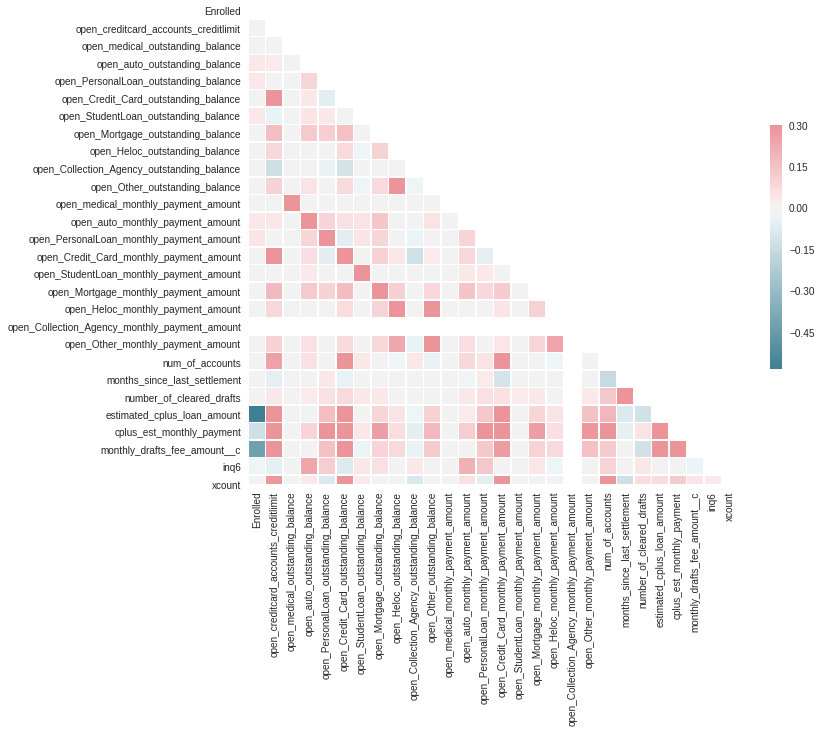

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Split Data

In [ ]:
df['is_open_auto_delinquent'].value_counts()

0    28140
1     1740
Name: is_open_auto_delinquent, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29880 entries, 34785 to 64664
Data columns (total 61 columns):
app_name                                                 29880 non-null object
lead_created_date_time                                   29880 non-null datetime64[ns]
Enrolled                                                 29880 non-null int64
fico9                                                    24074 non-null object
fdr_specified_creditors_mix                              29880 non-null object
num_Tradelines_open_last_6m                              29880 non-null object
months_since_first_tr_open                               29880 non-null object
open_creditcard_accounts_creditlimit                     29880 non-null float64
num_Tradelines_open_last_3m                              29880 non-null object
delinquency_bankruptcy_flag                              29880 non-null object
delinquency_foreclosure_flag                             29880 non-null object
delinquenc

In [ ]:
# change True False to Binary
def convert_to_binary(some_var):
    
    if pd.isnull(some_var):
        return 0
    if (some_var == True):
        return 1
      
    return 0

In [ ]:
df = model_data

In [ ]:
df['is_open_auto_delinquent'] = df.apply(lambda x: convert_to_binary(x['is_open_auto_delinquent']), axis=1)
df['is_open_personal_loan_delinquent'] = df.apply(lambda x: convert_to_binary(x['is_open_personal_loan_delinquent']), axis=1)
df['joint_tradeline_exists_all'] = df.apply(lambda x: convert_to_binary(x['joint_tradeline_exists_all']), axis=1)
df['joint_tradeline_exists_active'] = df.apply(lambda x: convert_to_binary(x['joint_tradeline_exists_active']), axis=1)

In [ ]:
# change cplus missing amounts to average 
def fix_miss(loan):
    
    if pd.isnull(loan):
        return loan*0.037
    return

In [ ]:
df['cplus_est_monthly_payment'] 

In [ ]:
df = df[df['estimated_cplus_loan_amount']<65000]
df = df[df['estimated_cplus_loan_amount']>5000]


In [ ]:
df['fico9']  = df['fico9'].astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22223 entries, 34790 to 64676
Data columns (total 62 columns):
app_name                                                 22223 non-null object
lead_created_date_time                                   22223 non-null datetime64[ns, UTC]
Enrolled                                                 22223 non-null int64
fico9                                                    18287 non-null float64
fdr_specified_creditors_mix                              22223 non-null object
num_Tradelines_open_last_6m                              22223 non-null object
months_since_first_tr_open                               22223 non-null object
open_creditcard_accounts_creditlimit                     22223 non-null float64
num_Tradelines_open_last_3m                              22223 non-null object
delinquency_bankruptcy_flag                              22223 non-null object
delinquency_foreclosure_flag                             22223 non-null object
deli

In [ ]:
df.describe()

,Enrolled,fico9,open_creditcard_accounts_creditlimit,open_medical_outstanding_balance,open_auto_outstanding_balance,open_PersonalLoan_outstanding_balance,open_Credit_Card_outstanding_balance,open_StudentLoan_outstanding_balance,open_Mortgage_outstanding_balance,open_Heloc_outstanding_balance,open_Collection_Agency_outstanding_balance,open_Other_outstanding_balance,open_medical_monthly_payment_amount,open_auto_monthly_payment_amount,open_PersonalLoan_monthly_payment_amount,open_Credit_Card_monthly_payment_amount,open_StudentLoan_monthly_payment_amount,open_Mortgage_monthly_payment_amount,open_Heloc_monthly_payment_amount,open_Collection_Agency_monthly_payment_amount,open_Other_monthly_payment_amount,is_open_auto_delinquent,is_open_personal_loan_delinquent,joint_tradeline_exists_all,joint_tradeline_exists_active,num_of_accounts,months_since_last_settlement,number_of_cleared_drafts,estimated_cplus_loan_amount,cplus_est_monthly_payment,monthly_drafts_fee_amount__c,inq6,xcount
count,22223.000000,18287.000000,22223.000000,22223.000000,22223.000000,22223.000000,22223.000000,22223.000000,2.222300e+04,22223.000000,22223.000000,22223.000000,22223.0,22223.000000,22223.000000,22222.000000,22223.000000,22223.000000,22223.000000,22223.0,22222.000000,22223.000000,22223.000000,22223.000000,22223.000000,22096.000000,19095.000000,22096.000000,22223.000000,2666.000000,21596.000000,22223.000000,22223.000000
mean,0.023759,608.658227,30095.929577,0.002250,13809.581650,4363.302569,19091.144400,10349.635918,5.296026e+04,1638.131980,339.937497,12249.832381,0.0,347.788327,181.288530,624.001935,52.944202,413.252846,10.999055,0.0,238.717622,0.059668,0.032534,0.753364,0.496963,7.252172,1.772454,12.681707,16078.145402,609.255349,339.826028,1.881405,3.677046
std,0.152301,76.117688,21037.628963,0.335404,17440.375085,8171.657459,12846.681841,30863.399101,1.010814e+05,12975.183926,1502.252513,27590.576294,0.0,384.674119,314.847164,394.014460,176.273254,739.844727,84.365934,0.0,397.474190,0.236876,0.177417,0.431063,0.500002,3.813845,2.442513,7.746879,8891.375478,306.926323,245.208153,2.703567,0.901033
min,0.000000,354.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,5004.871364,174.750000,0.000000,-1.000000,1.000000
25%,0.000000,554.000000,15730.000000,0.000000,0.000000,0.000000,10633.500000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,356.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000,7.000000,10016.362763,391.872500,200.000000,0.000000,3.000000
50%,0.000000,624.000000,25050.000000,0.000000,8709.000000,0.000000,16481.000000,0.000000,0.000000e+00,0.000000,0.000000,4160.000000,0.0,306.000000,0.000000,564.000000,0.000000,0.000000,0.000000,0.0,116.000000,0.000000,0.000000,1.000000,0.000000,6.000000,1.000000,12.000000,13628.895426,529.270000,284.000000,1.000000,4.000000
75%,0.000000,665.000000,38950.000000,0.000000,21449.500000,6337.000000,24452.500000,427.000000,8.056850e+04,0.000000,0.000000,12140.500000,0.0,525.000000,286.000000,813.750000,0.000000,744.000000,0.000000,0.0,324.000000,0.000000,0.000000,1.000000,1.000000,9.000000,3.000000,14.000000,19563.712287,738.295000,425.000000,2.700000,4.000000
max,1.000000,839.000000,236600.000000,50.000000,252450.000000,103781.000000,124140.000000,697695.000000,1.801531e+06,558147.000000,55828.000000,802321.000000,0.0,6511.000000,3690.000000,4775.000000,4978.000000,12277.000000,3219.000000,0.0,17657.000000,1.000000,1.000000,1.000000,1.000000,40.000000,33.000000,89.000000,64991.545182,3000.000000,10000.000000,12.740000,5.000000


In [ ]:
df['Enrolled'].value_counts()/len(df)

0    0.976241
1    0.023759
Name: Enrolled, dtype: float64

In [ ]:
df.isna().sum()

app_name                                                     0
lead_created_date_time                                       0
Enrolled                                                     0
fico9                                                     4030
fdr_specified_creditors_mix                                  0
num_Tradelines_open_last_6m                                  0
months_since_first_tr_open                                   0
open_creditcard_accounts_creditlimit                         0
num_Tradelines_open_last_3m                                  0
delinquency_bankruptcy_flag                                  0
delinquency_foreclosure_flag                                 0
delinquency_chargeoff_flag                                   0
delinquency_chargeoff_flag_fdr_eligible_account_types        0
Amex                                                         0
at_cu                                                        0
Discover                                               

In [ ]:
df.head()

,app_name,lead_created_date_time,Enrolled,fico9,fdr_specified_creditors_mix,num_Tradelines_open_last_6m,months_since_first_tr_open,open_creditcard_accounts_creditlimit,num_Tradelines_open_last_3m,delinquency_bankruptcy_flag,delinquency_foreclosure_flag,delinquency_chargeoff_flag,delinquency_chargeoff_flag_fdr_eligible_account_types,Amex,at_cu,Discover,Lending_club,credit_one_bank,onemain,us_bank,wells_fargo,open_medical_outstanding_balance,open_auto_outstanding_balance,open_PersonalLoan_outstanding_balance,open_Credit_Card_outstanding_balance,open_StudentLoan_outstanding_balance,open_Mortgage_outstanding_balance,open_Heloc_outstanding_balance,open_Collection_Agency_outstanding_balance,open_Other_outstanding_balance,open_medical_num_tradelines,open_auto_num_tradelines,open_PersonalLoan_num_tradelines,open_Credit_Card_num_tradelines,open_StudentLoan_num_tradelines,open_Mortgage_num_tradelines,open_Heloc_num_tradelines,open_Collection_Agency_num_tradelines,open_Other_num_tradelines,open_medical_monthly_payment_amount,open_auto_monthly_payment_amount,open_PersonalLoan_monthly_payment_amount,open_Credit_Card_monthly_payment_amount,open_StudentLoan_monthly_payment_amount,open_Mortgage_monthly_payment_amount,open_Heloc_monthly_payment_amount,open_Collection_Agency_monthly_payment_amount,open_Other_monthly_payment_amount,is_open_auto_delinquent,is_open_personal_loan_delinquent,joint_tradeline_exists_all,joint_tradeline_exists_active,first_premier_bank,billing_state,num_of_accounts,months_since_last_settlement,number_of_cleared_drafts,estimated_cplus_loan_amount,cplus_est_monthly_payment,inq6,xcount
34785,CPL00197386,2019-02-01 16:07:41,0,633.0,2,0,238,14400.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,9790.0,13039.0,8124.0,0.0,0.0,0.0,0.0,0,0,2,8,4,0,0,0,0,0.0,0.0,468.0,539.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,AR,10.0,2.0,13.0,16077.949255,NaN,1.0,4
34786,CPL00210637,2019-03-11 12:25:56,0,691.0,4,2,300,150180.0,2,0,0,0,0,0,2,1,1,0,0,1,0,0.0,43825.0,18366.0,102139.0,325277.0,0.0,0.0,0.0,8740.0,0,2,2,11,1,0,0,0,2,0.0,1143.0,1007.0,2609.0,73.0,0.0,0.0,0.0,109.0,0,0,1,1,0,NC,11.0,0.0,7.0,33582.035620,NaN,-1.0,4
34787,CPL00205584,2019-02-26 14:45:13,0,679.0,3,0,232,85800.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,4459.0,11068.0,21804.0,102.0,109052.0,0.0,0.0,8027.0,0,1,2,13,2,1,0,0,3,0.0,199.0,167.0,1075.0,56.0,776.0,0.0,0.0,232.0,0,0,0,0,0,TX,15.0,0.0,8.0,19904.948914,NaN,0.0,4
34788,CPL00189542,2019-01-04 16:09:16,0,654.0,2,2,185,11350.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,68446.0,4672.0,5949.0,0.0,0.0,0.0,0.0,27433.0,0,3,1,5,0,0,0,0,2,0.0,1770.0,140.0,295.0,0.0,0.0,0.0,0.0,888.0,0,0,1,1,0,MN,4.0,NaN,14.0,11289.887026,NaN,1.0,3
34789,CPL00223765,2019-04-19 10:31:03,0,NaN,2,1,385,42500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,30897.0,0.0,38983.0,0.0,0.0,20213.0,0,0,0,4,0,1,0,0,1,0.0,0.0,0.0,605.0,0.0,564.0,0.0,0.0,573.0,0,0,1,0,0,MI,4.0,3.0,8.0,25309.878761,NaN,1.0,4


# Select Variables

In [ ]:
variables = ['Enrolled', 'fico9']

In [ ]:
model_data = df.select_dtypes(np.number)

In [ ]:
model_data = model_data.drop(['cplus_est_monthly_payment'], axis=1)

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22472 entries, 34785 to 64664
Data columns (total 31 columns):
Enrolled                                         22472 non-null int64
fico9                                            18442 non-null float64
open_creditcard_accounts_creditlimit             22472 non-null float64
open_medical_outstanding_balance                 22472 non-null float64
open_auto_outstanding_balance                    22472 non-null float64
open_PersonalLoan_outstanding_balance            22472 non-null float64
open_Credit_Card_outstanding_balance             22472 non-null float64
open_StudentLoan_outstanding_balance             22472 non-null float64
open_Mortgage_outstanding_balance                22472 non-null float64
open_Heloc_outstanding_balance                   22472 non-null float64
open_Collection_Agency_outstanding_balance       22472 non-null float64
open_Other_outstanding_balance                   22472 non-null float64
open_medical_monthly_paym

In [ ]:
model_data = model_data.dropna()

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15504 entries, 34785 to 64662
Data columns (total 31 columns):
Enrolled                                         15504 non-null int64
fico9                                            15504 non-null float64
open_creditcard_accounts_creditlimit             15504 non-null float64
open_medical_outstanding_balance                 15504 non-null float64
open_auto_outstanding_balance                    15504 non-null float64
open_PersonalLoan_outstanding_balance            15504 non-null float64
open_Credit_Card_outstanding_balance             15504 non-null float64
open_StudentLoan_outstanding_balance             15504 non-null float64
open_Mortgage_outstanding_balance                15504 non-null float64
open_Heloc_outstanding_balance                   15504 non-null float64
open_Collection_Agency_outstanding_balance       15504 non-null float64
open_Other_outstanding_balance                   15504 non-null float64
open_medical_monthly_paym

In [ ]:
# segment out the variable we are predicting from the rest of the data
y = model_data['Enrolled']
X = model_data.drop(['Enrolled'], axis = 1)
print(X.shape, y.shape)

# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15504, 30) (15504,)
(12403, 30) (12403,)
(3101, 30) (3101,)


## Train Model

## Plot Predictions

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


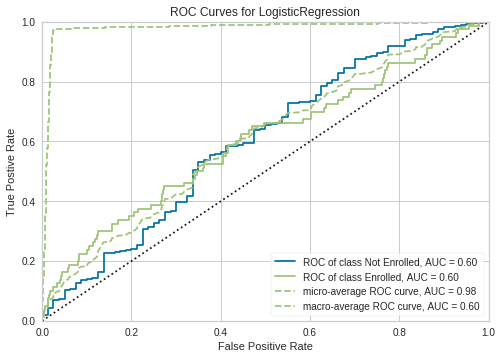

In [ ]:
# Set classes for all plots
classes = ['Not Enrolled', 'Enrolled']
model = LogisticRegression()
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(model, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

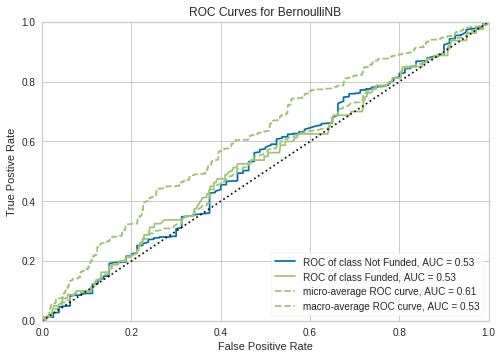

In [ ]:

# Set classes for all plots
classes = ['Not Funded', 'Funded']

class_prior = [0.5, 0.5] 
clf = BernoulliNB(class_prior=class_prior)

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(clf, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

In [ ]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(clf, classes=classes, support=True)

visualizer.fit(X_train, y_train.iloc[:,1])  # Fit the training data to the visualizer
visualizer.score(X_test, y_test.iloc[:,1])  # Evaluate the model on the test data
g = visualizer.poof()            # Draw/show/poof the data

# Random Forest

# Deep Neural Network (Keras)

In [ ]:
X_train.shape

(12403, 30)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras import models
from keras import layers
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
import datetime
import warnings

Using TensorFlow backend.


In [ ]:
# Create parameter variables for training
batch_size = 81
num_classes = 2
epochs = 25

model_one = models.Sequential()
model_one.add(layers.Dense(16, activation='relu', input_shape=(30,)))
model_one.add(layers.Dense(8, activation='relu')
model_one.add(layers.Dense(1, activation='softmax'))
#model_one.compile(optimizer='rmsprop',
#                      loss='categorical_crossentropy',
#                      metrics=['accuracy'])
#model_one.summary()

SyntaxError: ignored

In [ ]:
# Train the NN & record the time
warnings.filterwarnings('ignore')
start = datetime.datetime.now()

history_one = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                           epochs=epochs,
                           verbose=1)

end = datetime.datetime.now()
time_diff = end-start
print('Time to train = {}'.format(time_diff))